In [1]:
# 必要なライブラリのインポート．
from abc import ABC, abstractmethod
import os
import glob
from collections import deque
from time import time
from datetime import timedelta
import pickle
from base64 import b64encode
import math
import numpy as np
import torch
from torch import nn
from torch.distributions import Normal
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
from IPython.display import HTML

import robo_gym
from robo_gym.wrappers.exception_handling import ExceptionHandling

# Gymの警告を一部無視する．
gym.logger.set_level(40)
# matplotlibをColab上で描画するためのコマンド．
%matplotlib inline

In [2]:
def atanh(x):
    """ tanh の逆関数． """
    return 0.5 * (torch.log(1 + x + 1e-6) - torch.log(1 - x + 1e-6))


def evaluate_lop_pi(means, log_stds, actions):
    """ 平均(mean)，標準偏差の対数(log_stds)でパラメータ化した方策における，行動(actions)の確率密度の対数を計算する． """
    noises = (atanh(actions) - means) / (log_stds.exp() + 1e-8)
    return calculate_log_pi(log_stds, noises, actions)

In [3]:
def calculate_log_pi(log_stds, noises, actions):
    """ 確率論的な行動の確率密度を返す． """

    # NOTE: 入力はすべて (batch_size, |A|) となっているので，この関数では　batch_size　分の確率密度の対数 \log \pi(a|s) を
    # それぞれ独立に計算し (batch_size, 1) で返します．

    # ガウス分布 `N(0, stds * I)` における `noises * stds` の確率密度の対数(= \log \pi(u|a))を計算する．
    stds = log_stds.exp()
    gaussian_log_probs = Normal(torch.zeros_like(stds), stds).log_prob(stds * noises).sum(dim=-1, keepdim=True)

    # NOTE: gaussian_log_probs には (batch_size, 1) で表された確率密度の対数 \log p(u|s) が入っています．

    log_pis = gaussian_log_probs - torch.log(1 - actions**2 + 1e-6).sum(dim=-1, keepdim=True)

    return log_pis

In [4]:
def reparameterize(means, log_stds):
    """ Reparameterization Trickを用いて，確率論的な行動とその確率密度を返す． """

    # 標準偏差．
    stds = log_stds.exp()

    noises = torch.randn_like(means)
    actions = torch.tanh(means+noises*stds)

    # 確率論的な行動の確率密度の対数を計算する．
    log_pis = calculate_log_pi(log_stds, noises, actions)

    return actions, log_pis

In [5]:
def fix_state_dim(state):
    return np.concatenate([state['agent_pose'], state['occupancy_grid']])

In [6]:
class SACActor(nn.Module):

    def __init__(self, state_shape, action_shape):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2 * action_shape[0]),
        )

    def forward(self, states):
        means, log_stds = self.net(states).chunk(2, dim=-1)
        return torch.tanh(means)

    def sample(self, states):
        means, log_stds = self.net(states).chunk(2, dim=-1)
        log_stds = log_stds.clamp(-20, 2)
        return reparameterize(means, log_stds)

In [7]:
class SACCritic(nn.Module):

    def __init__(self, state_shape, action_shape):
        super().__init__()

        self.net1 = nn.Sequential(
            nn.Linear(state_shape[0] + action_shape[0], 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )
        self.net2 = nn.Sequential(
            nn.Linear(state_shape[0] + action_shape[0], 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, states, actions):
        sa = torch.cat([states, actions], dim=-1)
        q1 = self.net1(sa)
        q2 = self.net2(sa)
        return q1, q2

In [8]:
class ReplayBuffer:

    def __init__(self, buffer_size, state_shape, action_shape, device):
        # 次にデータを挿入するインデックス．
        self._p = 0
        # データ数．
        self._n = 0
        # リプレイバッファのサイズ．
        self.buffer_size = buffer_size

        # GPU上に保存するデータ．
        self.states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)
        self.actions = torch.empty((buffer_size, *action_shape), dtype=torch.float, device=device)
        self.rewards = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.dones = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.next_states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)

    def append(self, state, action, reward, done, next_state):
        self.states[self._p].copy_(torch.from_numpy(state))
        self.actions[self._p].copy_(torch.from_numpy(action))
        self.rewards[self._p] = float(reward)
        self.dones[self._p] = float(done)
        self.next_states[self._p].copy_(torch.from_numpy(next_state))

        self._p = (self._p + 1) % self.buffer_size
        self._n = min(self._n + 1, self.buffer_size)

    def sample(self, batch_size):
        idxes = np.random.randint(low=0, high=self._n, size=batch_size)
        return (
            self.states[idxes],
            self.actions[idxes],
            self.rewards[idxes],
            self.dones[idxes],
            self.next_states[idxes]
        )

In [9]:
class Algorithm(ABC):

    def explore(self, state):
        """ 確率論的な行動と，その行動の確率密度の対数 \log(\pi(a|s)) を返す． """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)
        with torch.no_grad():
            action, log_pi = self.actor.sample(state)
        return action.cpu().numpy()[0], log_pi.item()

    def exploit(self, state):
        """ 決定論的な行動を返す． """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze_(0)
        with torch.no_grad():
            action = self.actor(state)
        return action.cpu().numpy()[0]

    @abstractmethod
    def is_update(self, steps):
        """ 現在のトータルのステップ数(steps)を受け取り，アルゴリズムを学習するか否かを返す． """
        pass

    @abstractmethod
    def step(self, env, state, t, steps):
        """ 環境(env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
            受け取り，リプレイバッファへの保存などの処理を行い，状態・エピソードのステップ数を更新する．
        """
        pass

    @abstractmethod
    def update(self):
        """ 1回分の学習を行う． """
        pass

In [10]:
def init(module):
    nn.init.orthogonal_(module.weight.data, gain=nn.init.calculate_gain('relu'))
    nn.init.constant_(module.bias.data, 0)
    return module

class Encoder(nn.Module):
    
    def __init__(self, map_output=100, pose_output=50, map_size=128):
        super().__init__()
        self.map_size = map_size

        self.map_conv = nn.Sequential(
            # 128*128 -> 32*32
            init(nn.Conv2d(1, 16, kernel_size=8, stride=4, padding=2)),
            nn.ReLU(),
            # 32*32 -> 15*15
            init(nn.Conv2d(16, 32, kernel_size=4, stride=2)),
            nn.ReLU(),
            # 15*15 -> 13*13
            init(nn.Conv2d(32, 32, kernel_size=3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            # 32*13*13 -> map_output
            init(nn.Linear(32*13*13, map_output)),
            nn.ReLU()
        )
        self.pose_buf = nn.Sequential(
            # 3 -> pose_output
            init(nn.Linear(3, pose_output)),
            nn.ReLU()
        )
        
    def forward(self, obs):
        map_img = obs['occupancy_grid'].reshape((self.map_size, self.map_size)).T
        map_img = torch.tensor(map_img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        pose = torch.tensor(obs['agent_pose'], dtype=torch.float32)
        
        map_out = self.map_conv(map_img).squeeze()
        pose_out = self.pose_buf(pose).squeeze()
        return torch.cat([map_out, pose_out]).detach().numpy()

In [11]:
class Trainer:

    def __init__(self, env, env_test, algo, encoder, seed=0, num_steps=10**6, eval_interval=10**4, num_eval_episodes=3):

        self.env = env
        self.env_test = env_test
        self.algo = algo
        self.encoder = encoder

#         # 環境の乱数シードを設定する．
#         self.env.seed(seed)
#         self.env_test.seed(2**31-seed)

        # 平均収益を保存するための辞書．
        self.returns = {'step': [], 'return': []}

        # データ収集を行うステップ数．
        self.num_steps = num_steps
        # 評価の間のステップ数(インターバル)．
        self.eval_interval = eval_interval
        # 評価を行うエピソード数．
        self.num_eval_episodes = num_eval_episodes

    def train(self):
        """ num_stepsステップの間，データ収集・学習・評価を繰り返す． """

        # 学習開始の時間
        self.start_time = time()
        # エピソードのステップ数．
        t = 0

        # 環境を初期化する．
        # reset SLAM and generate new initial pose
        state = self.env.reset(new_room=False, new_agent_pose=True)
        with torch.no_grad():
            state = self.encoder(state)

        for steps in range(1, self.num_steps + 1):
            # 環境(self.env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
            # アルゴリズムに渡し，状態・エピソードのステップ数を更新する．
            
            state, t = self.algo.step(self.env, state, t, steps)

            # アルゴリズムが準備できていれば，1回学習を行う．
            if self.algo.is_update(steps):
                self.algo.update()

            # 一定のインターバルで評価する．
            if steps % self.eval_interval == 0:
                self.evaluate(steps)
                
    def evaluate(self, steps):
        """ 複数エピソード環境を動かし，平均収益を記録する． """

        returns = []
        for _ in range(self.num_eval_episodes):
            state = self.env_test.reset()
            state = fix_state_dim(state)
            done = False
            episode_return = 0.0

            while (not done):
                action = self.algo.exploit(state)
                print(action)
                state, reward, done, _ = self.env_test.step(action)
                with torch.no_grad():
                    state = self.encoder(state)
                episode_return += reward

            returns.append(episode_return)

        mean_return = np.mean(returns)
        self.returns['step'].append(steps)
        self.returns['return'].append(mean_return)

        print(f'Num steps: {steps:<6}   '
              f'Return: {mean_return:<5.1f}   '
              f'Time: {self.time}')
        
    def plot(self):
        """ 平均収益のグラフを描画する． """
        fig = plt.figure(figsize=(8, 6))
        plt.plot(self.returns['step'], self.returns['return'])
        plt.xlabel('Steps', fontsize=24)
        plt.ylabel('Return', fontsize=24)
        plt.tick_params(labelsize=18)
        plt.title(f'{self.env.unwrapped.spec.id}', fontsize=24)
        plt.tight_layout()

    @property
    def time(self):
        """ 学習開始からの経過時間． """
        return str(timedelta(seconds=int(time() - self.start_time)))

In [12]:
class SAC(Algorithm):

    def __init__(self, state_shape, action_shape, encoder, device=torch.device('cuda'), seed=0,
                 batch_size=256, gamma=0.99, lr_actor=3e-4, lr_critic=3e-4,
                 replay_size=10**6, start_steps=10**4, tau=5e-3, alpha=0.2, reward_scale=1.0):
        super().__init__()

        # シードを設定する．
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        # リプレイバッファ．
        self.buffer = ReplayBuffer(
            buffer_size=replay_size,
            state_shape=state_shape,
            action_shape=action_shape,
            device=device,
        )
        
        self.encoder = encoder

        # Actor-Criticのネットワークを構築する．
        self.actor = SACActor(
            state_shape=state_shape,
            action_shape=action_shape
        ).to(device)
        self.critic = SACCritic(
            state_shape=state_shape,
            action_shape=action_shape
        ).to(device)
        self.critic_target = SACCritic(
            state_shape=state_shape,
            action_shape=action_shape
        ).to(device).eval()

        # ターゲットネットワークの重みを初期化し，勾配計算を無効にする．
        self.critic_target.load_state_dict(self.critic.state_dict())
        for param in self.critic_target.parameters():
            param.requires_grad = False

        # オプティマイザ．
        self.optim_actor = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optim_critic = torch.optim.Adam(self.critic.parameters(), lr=lr_critic)

        # その他パラメータ．
        self.learning_steps = 0
        self.batch_size = batch_size
        self.device = device
        self.gamma = gamma
        self.start_steps = start_steps
        self.tau = tau
        self.alpha = alpha
        self.reward_scale = reward_scale

    def is_update(self, steps):
        # 学習初期の一定期間(start_steps)は学習しない．
        return steps >= max(self.start_steps, self.batch_size)

    def step(self, env, state, t, steps):
        t += 1

        # 学習初期の一定期間(start_steps)は，ランダムに行動して多様なデータの収集を促進する．
        if steps <= self.start_steps:
            action = env.action_space.sample()
        else:
            action, _ = self.explore(state)
        next_state, reward, done, _ = env.step(action)
        with torch.no_grad():
            next_state = self.encoder(next_state)
        
        
        # not ignore done

        # リプレイバッファにデータを追加する．
        self.buffer.append(state, action, reward, done, next_state)

        # エピソードが終了した場合には，環境をリセットする．
        if done:
            t = 0
            next_state = env.reset()
            with torch.no_grad():
                next_state = self.encoder(next_state)

        return next_state, t

    def update(self):
        self.learning_steps += 1
        states, actions, rewards, dones, next_states = self.buffer.sample(self.batch_size)

        self.update_critic(states, actions, rewards, dones, next_states)
        self.update_actor(states)
        self.update_target()

    def update_critic(self, states, actions, rewards, dones, next_states):
        # 現在のソフト状態行動価値を計算する．
        curr_qs1, curr_qs2 = self.critic(states, actions)

        with torch.no_grad():
            # ソフト状態価値のターゲットを計算します．
            # target_vs = ...
            next_actions, log_pis = self.actor.sample(next_states)
            qs1, qs2 = self.critic_target(next_states, next_actions)
            target_vs = torch.min(qs1, qs2) - self.alpha * log_pis

        # ソフト状態行動価値のターゲットを計算します．
        # target_qs = ...
        target_qs = rewards * self.reward_scale + (1 - dones) * self.gamma * target_vs

        loss_critic1 = (curr_qs1 - target_qs).pow_(2).mean()
        loss_critic2 = (curr_qs2 - target_qs).pow_(2).mean()

        self.optim_critic.zero_grad()
        (loss_critic1 + loss_critic2).backward(retain_graph=False)
        self.optim_critic.step()

    def update_actor(self, states):
        actions, log_pis = self.actor.sample(states)
        qs1, qs2 = self.critic(states, actions)
        loss_actor = (self.alpha * log_pis - torch.min(qs1, qs2)).mean()

        self.optim_actor.zero_grad()
        loss_actor.backward(retain_graph=False)
        self.optim_actor.step()

    def update_target(self):
        for t, s in zip(self.critic_target.parameters(), self.critic.parameters()):
            t.data.mul_(1.0 - self.tau)
            t.data.add_(self.tau * s.data)

In [13]:
ENV_ID = 'CubeRoomSearchLikeContinuously-v0'
target_machine_ip = 'localhost'
SEED = 0
REWARD_SCALE = 1.0
NUM_STEPS = 5 * 10 ** 4
EVAL_INTERVAL = 10 ** 3

map_enc = 100
pose_enc = 50

env = gym.make(ENV_ID, ip=target_machine_ip, gui=True, max_episode_steps=100)
env_test = gym.make(ENV_ID, ip=target_machine_ip, gui=True, max_episode_steps=100)

encoder = Encoder(map_enc, pose_enc, env.map_size)

# s_shape = (env.observation_space['agent_pose'].low.size + env.observation_space['occupancy_grid'].low.size, )
state_shape = (map_enc+pose_enc,)

algo = SAC(
    state_shape=state_shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    replay_size=10**6,
    reward_scale=REWARD_SCALE,
    encoder=encoder,
)

trainer = Trainer(
    env=env,
    env_test=env,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
    encoder=encoder,
)

Starting new Robot Server | Tentative 1
<class 'server_manager_pb2.RobotServer'>
True 
Successfully started Robot Server at localhost:44113
Starting new Robot Server | Tentative 1
<class 'server_manager_pb2.RobotServer'>
True 
Successfully started Robot Server at localhost:39143


In [14]:
trainer.train()

_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "Socket closed"
	debug_error_string = "{"created":"@1616939097.175174700","description":"Error received from peer ipv4:127.0.0.1:44113","file":"src/core/lib/surface/call.cc","file_line":1063,"grpc_message":"Socket closed","grpc_status":14}"
>

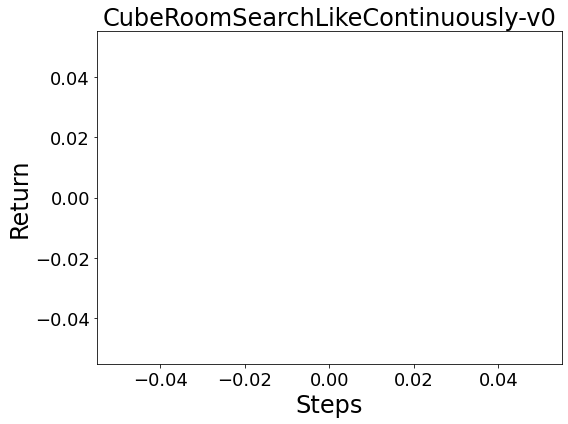

In [15]:
trainer.plot()

In [18]:
trainer.algo.buffer